# Hyperparameters
In this cell we perform a few tests values for a few hyperparameters that have a large affect on the performance of the model.
Firs, import the required libraires

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.optim import RAdam
from torch.utils.data import DataLoader
import tqdm
from IPython import display
sys.path.insert(1, '../')
import trans_tdsm, utils
import util.dataset_structure, util.display
# GPU device info
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"
os.system('nvidia-smi')

Check how the time is sampled to ensure we are training  on data with a fairly continuous noise perturbation

In [ ]:
sampled_times = []
for filename in files_list_:
        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(0.9 * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])
        
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=128, shuffle=True)

        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            incident_energies = incident_energies.to(device)
            random_t = torch.rand(incident_energies.shape[0], device=device) * (1. - 1e-3) + 1e-3
            sampled_times.extend(random_t.tolist())
            
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('time step')
ax.set_ylabel('# sampled')
hist = ax.hist(sampled_times, bins=np.linspace(0,1,100))

## Learning Rate
Choosing an appropriate learning rate can have a massive effect on the success of a model. The amount we are allowing the model to update its weights during gradient descent is controlled by the learning rate parameter:

$$
w:= w - \alpha \frac{dy}{dw}
$$

with $\alpha$ being our learning rate. Many things can affect what is an optimial learning rate for your training so you need to be aware that this may need updating if you change for instance your loss definition, pre-processing of the data, optimiser etc.

Here, we scan the learning rate from large to small as we progress through the epochs to see where the loss stabilises. We then choose this as a ballpark for our starting learning rate.

It's possible to have an adaptive learning rate in the real training using schedulers like this as well.

## Batch size
For the showers for dataset 1, the number of hits < 400, meaning we can safely load reasonable batch sizes and apply the attention mechanism in the encoder blocks without troubling the GPU memory too much. However, when we get to the larger shower sizes of datasets 2 and 3, we start to run into some problems.

Two possible solutions here are to either reduce the batch size or find a way around computing huge attention matrices.

Thu Oct 12 15:54:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:07.0 Off |                    0 |
| N/A   63C    P0    31W /  70W |   3305MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 0/50 [00:00<?, ?it/s]

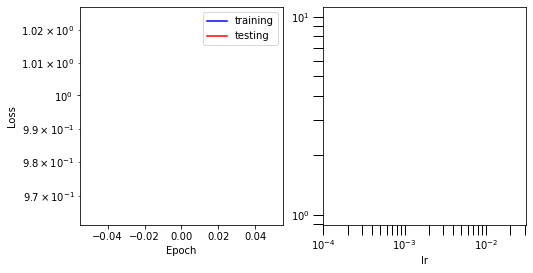

['/eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt']
Epoch: 0: lr: 0.0001000 -> 0.0001122 , Loss: 1.0240339


KeyboardInterrupt: 

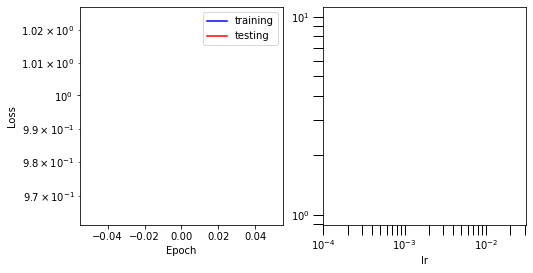

In [2]:
# Set padding value used
padding_value = 0.0

dataset = "dataset_2_padded_nentry"
preproc_dataset_name = 'ds2_diff_transforms'
dataset_store_path = os.path.join("/eos/user/j/jthomasw/tdsm_encoder/datasets/", preproc_dataset_name)
transform = None
transform_y = None
mask = True
jupyternotebook = True
workingdir = "./"

### SDE PARAMETERS ###
SDE = 'VP'
if SDE == 'VP':
    beta_max = 20.0
    beta_min = 0.01
if SDE == 'VE':
    sigma_max = 20.0
    sigma_min = 0.1
    
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 8
num_attn_heads = 16
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = utils.VPSDE(beta_max=beta_max,beta_min=beta_min, device=device)
if SDE == 'VE':
    sde = utils.VESDE(sigma_max=sigma_max,sigma_min=sigma_min,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

# Input files
files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '*424To564.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

# Instantiate model
model=trans_tdsm.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)
torch.save(model.state_dict(), 'initial_model.pt')

print(files_list_)

# Instantiate model each time (re-initialises weights)
model_tmp=trans_tdsm.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)

# Run the thing
### HYPERPARAMETERS ###
train_ratio = 0.8
batch_size = 128
n_epochs = 50
lr_ = 0.0001
epochs = tqdm.notebook.trange(n_epochs)
optimiser = RAdam(model_tmp.parameters(),lr=lr_)
av_training_losses_per_epoch = []
av_testing_losses_per_epoch = []

# Scheduler for optimiser
lambda1 = lambda epoch: 10**(epoch / 20)
scheduler = lr_scheduler.LambdaLR(optimiser, lr_lambda=lambda1)
#scheduler = lr_scheduler.LinearLR(optimiser, start_factor=0.001, end_factor=1.0, total_iters=n_epochs)
#scheduler = lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
dh = display.display(fig, display_id=True)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_yscale('log')
ax[1].set_xlabel('lr')
ax[1].set_xlim(lr_,lr_*10**(n_epochs/20))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].tick_params('both', length=10, width=1, which='both')

lrs_ = []
print(files_list_)

for epoch in epochs:

    # Create/clear per epoch variables
    cumulative_epoch_loss = 0.
    cumulative_test_epoch_loss = 0.

    file_counter = 0
    n_training_showers = 0
    n_testing_showers = 0
    training_batches_per_epoch = 0
    testing_batches_per_epoch = 0

    # Load files
    for filename in files_list_:
        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(train_ratio * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])

        n_training_showers+=train_size
        n_testing_showers+=test_size
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        shower_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # Accumuate number of batches per epoch
        training_batches_per_epoch += len(shower_loader_train)
        testing_batches_per_epoch += len(shower_loader_test)

        # Load shower batch for training
        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            # Move model to device and set dtype as same as data (note torch.double works on both CPU and GPU)
            model_tmp.to(device, shower_data.dtype)
            model_tmp.train()
            shower_data = shower_data.to(device)
            incident_energies = incident_energies.to(device)

            if len(shower_data) < 1:
                print('Very few hits in shower: ', len(shower_data))
                continue
            # Zero any gradients from previous steps
            optimiser.zero_grad()
            # Loss average for each batch
            loss = trans_tdsm.loss_fn(model_tmp, shower_data, incident_energies, marginal_prob_std_fn, padding_value, device=device)
            # Accumulate batch loss per epoch
            cumulative_epoch_loss+=float(loss)
            # collect dL/dx for any parameters (x) which have requires_grad = True via: x.grad += dL/dx
            loss.backward()
            # Update value of x += -lr * x.grad
            optimiser.step()

        # Testing on subset of file
        for i, (shower_data,incident_energies) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                model_tmp.eval()
                shower_data = shower_data.to(device)
                incident_energies = incident_energies.to(device)
                test_loss = trans_tdsm.loss_fn(model_tmp, shower_data, incident_energies, marginal_prob_std_fn, padding_value, device=device)
                cumulative_test_epoch_loss+=float(test_loss)

    # Calculate average loss per epoch
    av_training_losses_per_epoch.append(cumulative_epoch_loss/training_batches_per_epoch)
    av_testing_losses_per_epoch.append(cumulative_test_epoch_loss/testing_batches_per_epoch)
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test)'.format(cumulative_epoch_loss/training_batches_per_epoch, cumulative_test_epoch_loss/testing_batches_per_epoch))
    ax[0].plot(av_training_losses_per_epoch, c='blue', label='training')
    ax[0].plot(av_testing_losses_per_epoch, c='red', label='testing')
    if epoch == 0:
        ax[0].legend(loc='upper right')
    
    # End of epoch, change the learning rate
    before_lr = optimiser.param_groups[0]['lr']
    scheduler.step()
    after_lr = optimiser.param_groups[0]['lr']
    print("Epoch: %d: lr: %.7f -> %.7f , Loss: %.7f" % (epoch, before_lr, after_lr, cumulative_epoch_loss/training_batches_per_epoch))
    lrs_.append(before_lr)
    # Plot the loss in log scale
    ax[1].plot(lrs_, av_training_losses_per_epoch, c='blue')
    dh.update(fig)